In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys

In [10]:
data = np.loadtxt(open("mnist_train_small.csv", "rb"), delimiter=",")

# shape of the data matrix
# print(data.shape)

# extract labels (number IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


In [11]:
# normalize data
dataNorm = data / np.max(data)

# scumble the data
np.random.seed(42)
scumbleIndex = np.random.permutation(dataNorm.shape[1])
dataNorm = dataNorm[:, scumbleIndex]

# convert to tensor
dataTensor = torch.tensor(dataNorm, dtype=torch.float)
labelsTensor = torch.tensor(labels, dtype=torch.long)

# split into training and test set
train_data, test_data, train_labels, test_labels = train_test_split(
    dataTensor, labelsTensor, test_size=0.2, random_state=42
)

# convert to torch dataset and to dataloader
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

In [34]:
print("Number of training samples: %i" % len(train_dataset))
print("Number of test samples: %i" % len(test_dataset))
print("Number of batches: %i" % len(train_loader))
print("Shape of one batch: %s" % str(next(iter(train_loader))[0].shape))

Number of training samples: 16000
Number of test samples: 4000
Number of batches: 500
Shape of one batch: torch.Size([32, 784])


In [48]:
def show_digit_pic(index, data, labels):
    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(index))):
        plt.subplot(1, 5, i + 1)
        img = np.reshape(data[index[i], :], (28, 28))
        plt.imshow(img, cmap="gray")
        plt.title("The number %i" % labels[index[i]])
    plt.show()

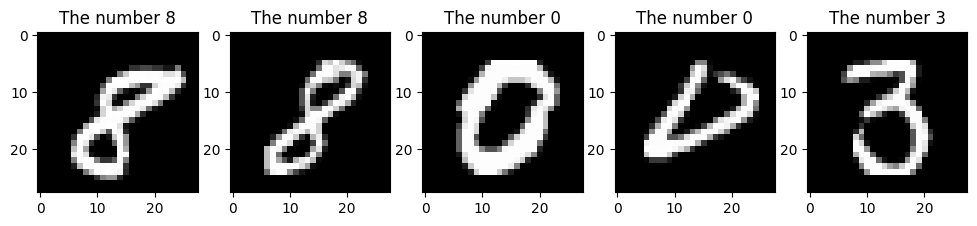

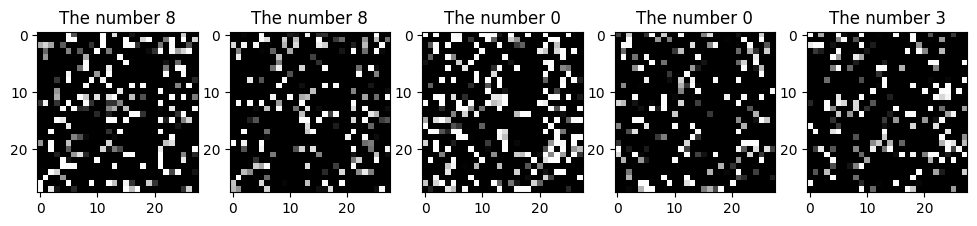

In [49]:
# get 5 random indices and show the corresponding images
indices = np.random.choice(np.arange(data.shape[0]), 5)
show_digit_pic(indices, data, labels)
show_digit_pic(indices, dataNorm, labels)

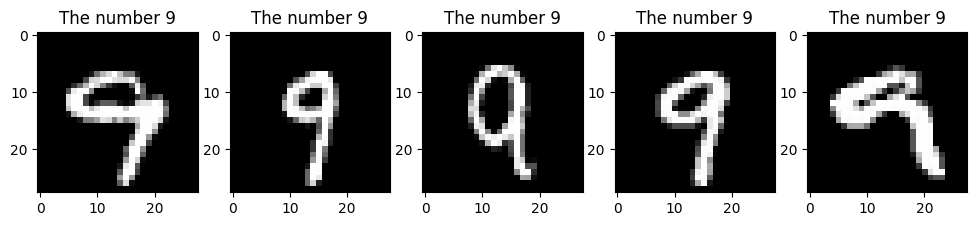

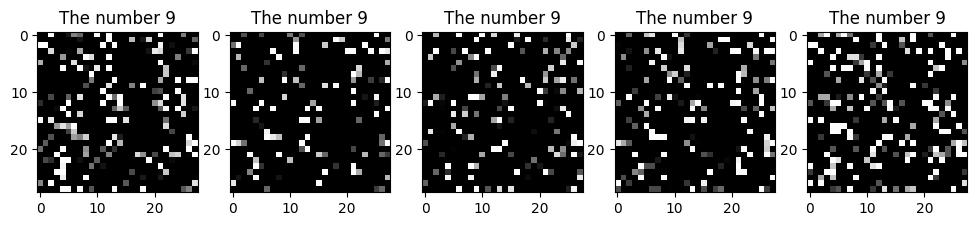

In [33]:
n=9
indices = np.where(labels==n)[0][:5]
show_digit_pic(indices, data, labels)
show_digit_pic(indices, dataNorm, labels)


In [35]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(784, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)
        self.dr = 0.4

    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = nn.BatchNorm1d(128)(x)
        
        x = F.dropout(x, p=self.dr, training=self.training)
        
        x = self.hidden1(x)
        x = F.relu(x)
        x = nn.BatchNorm1d(64)(x)
        
        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.hidden2(x)
        x = F.relu(x)
        x = nn.BatchNorm1d(32)(x)
        
        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.output(x)
        x = F.log_softmax(x, dim=1)
        return x
    
def create_model():
    model = ANN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.NLLLoss()
    return model, optimizer, criterion

In [ ]:
# test the model
test_model, test_optimizer, test_criterion = create_model()
test_input = torch.randn(64, 784)
test_output = test_model(test_input)
print("Shape of input: %s" % str(test_input.shape))
print(torch.exp(test_output))  # output is log-probabilities, use exp to get probabilities

In [42]:
def train_model(train_loader, test_loader):
    epochs = 50
    model, optimizer, criterion = create_model()
    losses = np.zeros(epochs)
    trainAcc = np.zeros(epochs)
    testAcc = np.zeros(epochs)

    for i in range(epochs):
        model.train()
        batchAcc = []
        bactchLoss = []
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batchAcc.append(
                100 * torch.mean((labels == torch.argmax(outputs, dim=1)).float())
            )
            bactchLoss.append(loss.item())
        losses[i] = np.mean(bactchLoss)
        trainAcc[i] = np.mean(batchAcc)

        # test model
        model.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            outputs = model(x)
            testAcc[i] = 100 * torch.mean((y == torch.argmax(outputs, dim=1)).float())
        msg = f"Epoch: {i+1}/{epochs}, Train acc: {trainAcc[i]:.2f}"
        sys.stdout.write("\r" + msg)

    return model, losses, trainAcc, testAcc

In [43]:
# train a model
model, losses, trainAcc, testAcc = train_model(train_loader, test_loader)

# approx time: 3 min

Epoch: 50/50, Train acc: 94.88

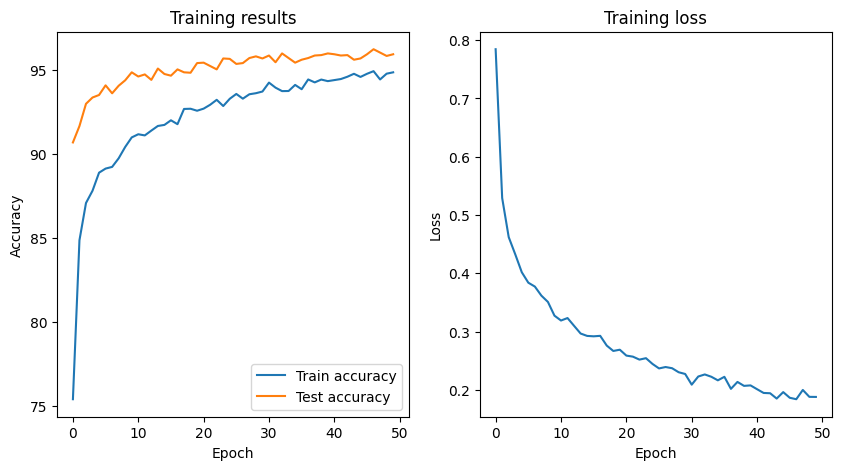

In [44]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(trainAcc, label="Train accuracy")
plt.plot(testAcc, label="Test accuracy")
plt.legend()
plt.title("Training results")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

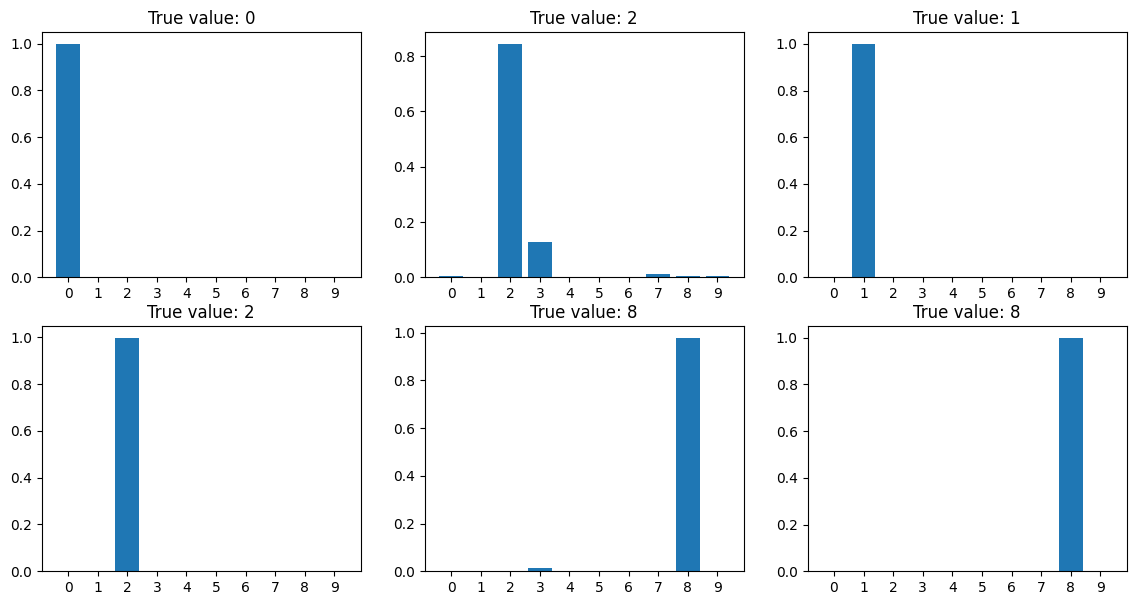

In [65]:
# plot some sample
random_indexs = np.random.randint(0, len(test_dataset), 6)
x, y = test_dataset[random_indexs]
prediction = model(x).detach()

plt.figure(figsize=(14, 7))
for i, pred in enumerate(prediction):
    plt.subplot(2, 3, i + 1)
    plt.bar(range(10), torch.exp(pred))
    plt.xticks(np.arange(10))
    plt.title(f"True value: {y[i]}")
plt.show()